In [1]:
%matplotlib inline

import tensorflow as tf
from train_rnn_last import get_batches, get_pretrain_batches
from preprocess import write_video
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def put_kernels_on_grid (kernel, grid_Y, grid_X, pad = 1):

    '''Visualize conv. features as an image (mostly for the 1st layer).
    Place kernel into a grid, with some paddings between adjacent filters.

    Args:
      kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
      (grid_Y, grid_X):  shape of the grid. Require: NumKernels == grid_Y * grid_X
                           User is responsible of how to break into two multiples.
      pad:               number of black pixels around each filter (between them)

    Return:
      Tensor of shape [(Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels, 1].
    '''

    x_min = tf.reduce_min(kernel)
    x_max = tf.reduce_max(kernel)

    kernel1 = (kernel - x_min) / (x_max - x_min)

    # pad X and Y
    x1 = tf.pad(kernel1, tf.constant( [[pad,pad],[pad, pad],[0,0],[0,0]] ), mode = 'CONSTANT')

    # X and Y dimensions, w.r.t. padding
    Y = kernel1.get_shape()[0] + 2 * pad
    X = kernel1.get_shape()[1] + 2 * pad

    channels = kernel1.get_shape()[2]

    # put NumKernels to the 1st dimension
    x2 = tf.transpose(x1, (3, 0, 1, 2))
    # organize grid on Y axis
    x3 = tf.reshape(x2, tf.pack([grid_X, Y * grid_Y, X, channels])) #3

    # switch X and Y axes
    x4 = tf.transpose(x3, (0, 2, 1, 3))
    # organize grid on X axis
    x5 = tf.reshape(x4, tf.pack([1, X * grid_X, Y * grid_Y, channels])) #3

    # back to normal order (not combining with the next step for clarity)
    x6 = tf.transpose(x5, (2, 1, 3, 0))

    # to tf.image_summary order [batch_size, height, width, channels],
    #   where in this case batch_size == 1
    x7 = tf.transpose(x6, (3, 0, 1, 2))

    # scale to [0, 255] and convert to uint8
    return tf.image.convert_image_dtype(x7, dtype = tf.uint8) 

def visualize(tensor):
    weights = tensor.eval()
    assert(weights.shape[0] == weights.shape[1])
    width = weights.shape[0]
    channels = weights.shape[2]
    filters = weights.shape[3]
    
    tiling = math.ceil(math.sqrt(channels * filters))
    output_width = tiling * width
    output = np.zeros((output_width, output_width))
    row, col = 0, 0
    for i in range(channels):
        for j in range(filters):
            output[width*row:width*(row+1),width*col:width*(col+1)] = weights[:,:,i,j]
            col += 1
            if col == tiling:
                col = 0
                row += 1
            
    return output

def get_summaries(tensor, name):
    channels = tf.split(2, tensor.get_shape()[2], tensor)
    tensors = []
    for t in channels:
        tensors += tf.split(3, int(t.get_shape()[3]) / 16, t)
    
    return [tf.image_summary("{}/{}".format(name, i), put_kernels_on_grid(w, 4, 4), max_images=1) for (i,w) in enumerate(tensors)]

def extract_last_relevant(outputs):
    """
    Args:
        outputs: [Tensor(batch_size, output_neurons)]: A list containing the output
            activations of each in the batch for each time step as returned by
            tensorflow.models.rnn.rnn.
        length: Tensor(batch_size): The used sequence length of each example in the
            batch with all later time steps being zeros. Should be of type tf.int32.

    Returns:
        Tensor(batch_size, output_neurons): The last relevant output activation for
            each example in the batch.
    """
    # Query shape.
    batch_size = int(outputs.get_shape()[0])
    max_length = int(outputs.get_shape()[1])
    num_neurons = int(outputs.get_shape()[2])
    # Index into flattened array as a workaround.
    index = tf.range(0, batch_size) * max_length + (max_length - 1)
    flat = tf.reshape(outputs, [-1, num_neurons])
    relevant = tf.gather(flat, index)
    return relevant

def bias(num_units, init):
    return tf.Variable(tf.constant(init, shape=[num_units]))

def weights(shape, stddev):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))

def conv2d(inp, b, w):
    return tf.nn.relu(tf.nn.conv2d(inp, w, strides=[1,1,1,1], padding='SAME') + b)

def pool2d(inp):
    return tf.nn.max_pool(inp, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def pool3d(inp):
    return tf.nn.max_pool3d(inp, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')

def layer(inp, num_units, filter_shape):
    num_channels = int(inp.get_shape()[4])
    b = bias(num_units, 0.2)
    w = weights(filter_shape + [num_channels, num_units], 0.04)
    conv = [conv2d(i, b, w) for i in tf.unpack(inp, axis=1)]
    out = pool3d(tf.pack(conv, axis=1))
    return b,w,conv,out

def layer2d(inp, num_units, filter_shape):
    num_channels = int(inp.get_shape()[4])
    b = bias(num_units, 0.2)
    w = weights(filter_shape + [num_channels, num_units], 0.04)
    conv = [conv2d(i, b, w) for i in tf.unpack(inp, axis=1)]
    o_pool = tf.pack([pool2d(c) for c in conv], axis=1)
    return b,w,conv,o_pool

def dense(inp, num_in, num_out, b_init, w_init):
    b = bias(num_out, b_init)
    w = weights([num_in, num_out], w_init)
    h = tf.nn.relu(tf.matmul(inp, w) + b)
    
    return b, w, h

def dense_multi(inp, num_in, num_out, b_init, w_init):
    b = bias(num_out, b_init)
    w = weights([num_in, num_out], w_init)
    unpacked = tf.unpack(inp, axis=1)
    h = [tf.nn.relu(tf.matmul(i, w) + b) for i in unpacked]
    return b, w, tf.pack(h, axis=1)

def flatten(inp):
    shape = inp.get_shape()[1:].num_elements()
    reshaped = tf.reshape(inp, [-1, shape])
    return reshaped

def flatten_multi(inp):
    seq_len = int(inp.get_shape()[1])
    shape = inp.get_shape()[2:].num_elements()
    reshaped = tf.reshape(inp, [-1, seq_len, shape])
    return reshaped

def lstm(inp, num_units, num_layers, batch_size, name):
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units)
    #cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers)
    initial = cell.zero_state(batch_size, tf.float32)
    
    out, _ = tf.nn.dynamic_rnn(
        cell,
        inp,
        initial_state=initial,
        time_major=False,
        scope=name)
    
    return out

In [3]:
seq_len = 32
batch_size = 20

x_h = tf.placeholder(tf.float32, shape=[None, seq_len, 64, 64, 2])
x_m = tf.placeholder(tf.float32, shape=[None, seq_len, 64, 64, 2])
y_next = tf.placeholder(tf.float32, shape=[None, 32, 32])
#y = tf.placeholder(tf.float32, shape=[None, 20])

# Convolutional layers, hand
b_conv1_h, w_conv1_h, h_conv1_h, i_conv2_h = layer2d(x_h, 16, [5, 5])
b_conv2_h, w_conv2_h, h_conv2_h, i_conv3_h = layer2d(i_conv2_h, 32, [5, 5])
b_conv3_h, w_conv3_h, h_conv3_h, o_h = layer2d(i_conv3_h, 64, [4, 4])

# Convolutional layers, main
b_conv1_m, w_conv1_m, h_conv1_m, i_conv2_m = layer2d(x_m, 16, [5, 5])
b_conv2_m, w_conv2_m, h_conv2_m, i_conv3_m = layer2d(i_conv2_m, 32, [5, 5])
b_conv3_m, w_conv3_m, h_conv3_m, o_m = layer2d(i_conv3_m, 64, [4, 4])

# Merge hand and main
flat = flatten_multi(tf.pack([o_h, o_m], axis=2))

o_lstm = lstm(flat, 1024, 2, batch_size, "lstm")
last_index = int(o_lstm.get_shape()[1]) - 1
o_lstm_last = tf.squeeze(tf.slice(o_lstm, [0, last_index, 0], [batch_size, 1, 1024]), [1])

ValueError: Cannot infer num from shape (?, ?, 64, 64, 2)

In [73]:
b = next(batches)
p = o_lstm_last.eval(feed_dict={x_h: b[0], x_m: b[1], y_next: b[2]})
plt.imshow(np.reshape(p[0], (2, 64, 64, 2))[1,:,:,0], 'gray')

In [8]:
#diff_next = tf.nn.l2_normalize(tf.reshape(y_next, [-1, 64 * 64 * 4]), 1) - tf.nn.l2_normalize(o_decoder, 1)
diff_next = o_lstm_last - tf.reshape(y_next, [-1, 1024])
loss_next = tf.nn.l2_loss(diff_next)
pretrain_step = tf.train.AdamOptimizer(1e-4).minimize(loss_next)

In [9]:
CHALAP = "/media/amey/76D076A5D0766B6F/chalap"
MODEL = "2d-pool-pretrain"

# Create variables
step = 0
losses = []
sess = tf.InteractiveSession()
saver = tf.train.Saver()

# Initialize/restore
sess.run(tf.initialize_all_variables())
#saver.restore(sess, "{}/checkpoints/{}-9".format(CHALAP, MODEL))

In [10]:
for epoch in range(20):
    batches = get_pretrain_batches(batch_size, seq_len + 1)
    for i,batch in enumerate(batches):
        step += 1
        l, _ = sess.run([loss_next, pretrain_step], feed_dict={x_h:batch[0], x_m:batch[1], y_next: batch[2]})
        losses.append(l)
        if i%1000 == 0:
            print("step %d, training loss %g"%(i, l))
            #summary_writer.add_summary(loss_summary_op.eval(feed_dict={loss_summary: l}), step)

    saver.save(sess, "{}/checkpoints/{}".format(CHALAP, MODEL), global_step=epoch)
    print("Done with epoch: %d" % (epoch))

step 0, training loss 3.28074e+08
step 1000, training loss 1.87337e+08
step 2000, training loss 3.86481e+08
step 3000, training loss 1.96804e+08
step 4000, training loss 4.04301e+08
step 5000, training loss 3.6977e+08
step 6000, training loss 2.74012e+08
step 7000, training loss 2.70581e+08
step 8000, training loss 4.24004e+08
step 9000, training loss 3.86119e+08
step 10000, training loss 2.71274e+08
step 11000, training loss 1.97496e+08
step 12000, training loss 3.74431e+08
Done with epoch: 0
step 0, training loss 3.24759e+08
step 1000, training loss 1.87337e+08
step 2000, training loss 3.86481e+08
step 3000, training loss 1.96804e+08
step 4000, training loss 4.04301e+08
step 5000, training loss 3.6977e+08
step 6000, training loss 2.74012e+08
step 7000, training loss 2.70581e+08
step 8000, training loss 4.24004e+08
step 9000, training loss 3.86119e+08
step 10000, training loss 2.71274e+08
step 11000, training loss 1.97496e+08
step 12000, training loss 3.74431e+08
Done with epoch: 1
st

KeyboardInterrupt: 

In [8]:
#b_fc1, w_fc1, h_fc1 = dense_multi(flat, int(flat.get_shape()[2]), 2048, 0.1, 0.02)
b_fc1, w_fc1, h_fc1 = dense(flat, int(flat.get_shape()[1]), 512, 0.1, 0.02)

#o_lstm = lstm(h_fc1, 512, 2, batch_size, "lstm_h")
#last_index = int(o_lstm.get_shape()[1]) - 1
#o_lstm_last = tf.squeeze(tf.slice(o_lstm, [0, last_index, 0], [batch_size, 1, 512]), [1])

b_output = bias(20, 0.1)
w_output = weights([512, 20], 0.02)
#output = tf.matmul(o_lstm_last, w_output) + b_output
output = tf.matmul(h_fc1, w_output) + b_output

# Computations
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
CHALAP = "/media/amey/76D076A5D0766B6F/chalap"
MODEL = "2d-pool-pretrain"

# Create variables
step = 0
acc = []
sess = tf.InteractiveSession()
summary_writer = tf.train.SummaryWriter("{}/summaries".format(CHALAP), sess.graph)
saver = tf.train.Saver()
accuracy_summary = tf.placeholder(tf.float32, [])

# Initialize/restore
sess.run(tf.initialize_all_variables())
#saver.restore(sess, "{}/checkpoints/{}-9".format(CHALAP, MODEL))

# Create summary tensors
image_summaries = get_summaries(w_conv1_h, "conv1") + \
                  get_summaries(w_conv2_h, "conv2") + \
                  get_summaries(w_conv3_h, "conv3")
accuracy_summary_op = tf.scalar_summary("train_accuracy", accuracy_summary)

In [ ]:
for epoch in range(20):
    batches = get_batches(batch_size, seq_len)
    for i,batch in enumerate(batches):
        step += 1
        train_accuracy, _ = sess.run([accuracy, train_step], feed_dict={x_h:batch[0], x_m:batch[1], y: batch[2]})
        acc.append(train_accuracy)
        if i%100 == 0:
            cumulative = sum(acc) / len(acc)
            print("step %d, training accuracy %g"%(i, cumulative))
            for summary in image_summaries:
                summary_writer.add_summary(summary.eval(), step)
            summary_writer.add_summary(accuracy_summary_op.eval(feed_dict={accuracy_summary: cumulative}), step)

    saver.save(sess, "{}/checkpoints/{}".format(CHALAP, MODEL), global_step=epoch)
    print("Done with epoch: %d" % (epoch))

In [33]:
batches = get_batches(batch_size, seq_len)

In [16]:
b = next(batches)
np.argmax(output.eval(feed_dict={x_h: b[0], x_m: b[1], y: b[2]}), axis=1)

array([15,  7, 18, 18])

In [12]:
np.argmax(b[2], axis=1)

array([ 0,  0,  0,  0,  0,  0, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       12, 15, 15])

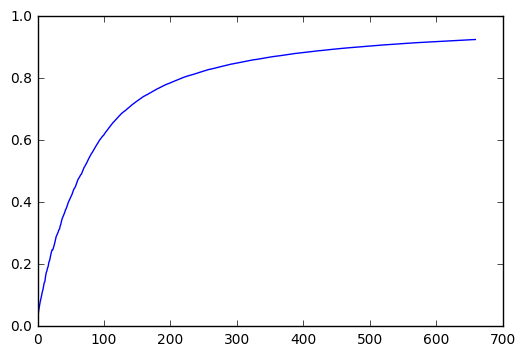

In [9]:
plt.plot(x_axis, temp)